## AT&T

In [1]:
# This code imports the data you generated before for replicating.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential

stock_prices = pd.read_csv('stock_prices.csv')
arima_predictions_T = pd.read_csv('arima_predictions_T')#predictions based on test set
arima_predictions_T = arima_predictions_T.set_index('timestamp')
arima_predictions_T.index.names = ['index']
arima_predictions_VZ = pd.read_csv('arima_predictions_VZ')#predictions based on test set
arima_predictions_VZ = arima_predictions_VZ.set_index('timestamp')
arima_predictions_VZ.index.names = ['index']
residual_T = pd.read_csv('residual_T.csv')
residual_T = residual_T.set_index('Unnamed: 0')
residual_VZ = pd.read_csv('residual_VZ.csv')
residual_VZ = residual_VZ.set_index('Unnamed: 0')


prediction_arima_T = pd.read_csv('prediction_arima_T.csv')#predictions based on training set
prediction_arima_T = prediction_arima_T.set_index('Unnamed: 0')
prediction_arima_T.index.names = ['index']
prediction_arima_VZ = pd.read_csv('prediction_arima_VZ.csv')
prediction_arima_VZ = prediction_arima_VZ.set_index('Unnamed: 0')
prediction_arima_VZ.index.names = ['index']


diff_T = stock_prices['T'].diff().dropna()
diff_VZ = stock_prices['VZ'].diff().dropna()
split = int(len(diff_T.values)*0.95)
diff_train_T = diff_T.iloc[:split]
diff_test_T = diff_T.iloc[split:]
diff_train_VZ = diff_VZ.iloc[:split]
diff_test_VZ = diff_VZ.iloc[split:]

In [2]:
train_extended_T = np.array(diff_train_T) + np.array(residual_T.values[1:].flatten())

In [3]:
n_steps = 10
n_features = 1

In [4]:
# This code is gathered from previous part and used here for replicating.

def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
X_train_res_T, y_train_res_T = split_sequence(train_extended_T, n_steps)
X_train_res_T = X_train_res_T.reshape((X_train_res_T.shape[0],  X_train_res_T.shape[1], n_features))
X_test_res_T, y_test_res_T = split_sequence(diff_test_T.values, n_steps)
X_test_res_T = X_test_res_T.reshape((X_test_res_T.shape[0],  X_test_res_T.shape[1], n_features))

In [6]:
model = Sequential()
model.add(LSTM(128, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam' , loss='mean_squared_error',metrics=['mse'])

In [7]:
history = model.fit(X_train_res_T, y_train_res_T, batch_size= 200,
                    epochs=200,verbose=0)

In [8]:
start = X_test_res_T[X_test_res_T.shape[0]-1]
T_input = start
T_input = T_input.reshape((1, n_steps, n_features))

In [9]:
DL_predictions_T = []

for i in range(len(arima_predictions_T)):
    T_input = T_input.reshape((1, n_steps, n_features))
    yhat_lstm = model.predict(T_input, verbose=0)
    T_input = np.append(T_input, yhat_lstm)
    T_input = T_input[1:]
    DL_predictions_T.append(yhat_lstm)

In [10]:
prediction_arima_T = np.array(prediction_arima_T).flatten()

In [11]:
predict_arima_res = pd.DataFrame(prediction_arima_T)[ - (1 + len(arima_predictions_T)):].reset_index()
del predict_arima_res['index']

In [12]:
hybrid_prediction = pd.DataFrame(np.array(DL_predictions_T).flatten()) + predict_arima_res.diff()[1:].reset_index()
del hybrid_prediction['index']

In [13]:
df_train_extended_T = pd.DataFrame(train_extended_T)
df_train_extended_T.index = diff_train_T.index

In [14]:
df_diff_test_T = pd.DataFrame(diff_test_T)
df_diff_test_T.index = pd.to_datetime(df_diff_test_T.index)

In [15]:
hybrid_prediction.set_index(df_diff_test_T[ - len(arima_predictions_T):].index, inplace=True)

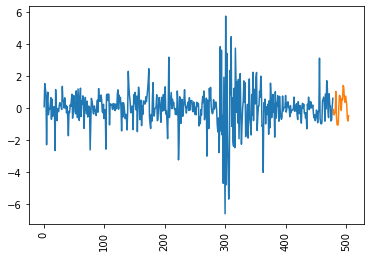

In [16]:
plt.plot(df_train_extended_T.index, df_train_extended_T.values)
plt.plot(diff_test_T[ - len(hybrid_prediction):].index, np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

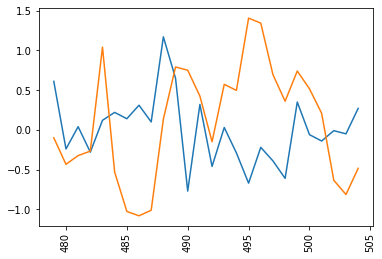

In [17]:
plt.plot(diff_test_T[ - len(hybrid_prediction):].index,
         diff_test_T[ - len(hybrid_prediction):])
plt.plot(diff_test_T[ - len(hybrid_prediction):].index,
         np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

In [18]:
def rmse(y,yhat):
    return np.sqrt(mean_squared_error(y,yhat))

In [19]:
hybrid_rmse = rmse(np.array(diff_test_T[ - len(hybrid_prediction):].values),
                   hybrid_prediction)
print('Hybrid RMSE is {:.4f}'.format(hybrid_rmse))

Hybrid RMSE is 0.9209


## Verizon

In [20]:
train_extended_VZ = np.array(diff_train_VZ) + np.array(residual_VZ.values[1:].flatten())

In [21]:
train_extended_T = np.array(diff_train_T) + np.array(residual_T.values[1:].flatten())

In [22]:
X_train_res_VZ, y_train_res_VZ = split_sequence(train_extended_VZ, n_steps)
X_train_res_VZ = X_train_res_VZ.reshape((X_train_res_VZ.shape[0],  X_train_res_VZ.shape[1], n_features))
X_test_res_VZ, y_test_res_VZ = split_sequence(diff_test_VZ.values, n_steps)
X_test_res_VZ = X_test_res_VZ.reshape((X_test_res_VZ.shape[0],  X_test_res_VZ.shape[1], n_features))

In [23]:
model = Sequential()
model.add(LSTM(128, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer = 'adam' , loss='mean_squared_error',metrics=['mse'])

In [24]:
history = model.fit(X_train_res_VZ, y_train_res_VZ, batch_size= 200,
                    epochs=200,verbose=0)

In [25]:
start = X_test_res_VZ[X_test_res_VZ.shape[0]-1]
VZ_input = start
VZ_input = VZ_input.reshape((1, n_steps, n_features))

In [26]:
DL_predictions_VZ = []

for i in range(len(arima_predictions_VZ)):
    VZ_input = VZ_input.reshape((1, n_steps, n_features))
    yhat_lstm = model.predict(VZ_input, verbose=0)
    VZ_input = np.append(VZ_input, yhat_lstm)
    VZ_input = VZ_input[1:]
    DL_predictions_VZ.append(yhat_lstm)

In [27]:
prediction_arima_VZ = np.array(prediction_arima_VZ).flatten()

In [28]:
predict_arima_res = pd.DataFrame(prediction_arima_VZ)[ - (1 + len(arima_predictions_VZ)):].reset_index()
del predict_arima_res['index']

In [29]:
hybrid_prediction = pd.DataFrame(np.array(DL_predictions_VZ).flatten()) + predict_arima_res.diff()[1:].reset_index()
del hybrid_prediction['index']

In [30]:
df_train_extended_VZ = pd.DataFrame(train_extended_VZ)
df_train_extended_VZ.index = diff_train_VZ.index

In [31]:
df_diff_test_VZ = pd.DataFrame(diff_test_VZ)
df_diff_test_VZ.index = pd.to_datetime(df_diff_test_VZ.index)

In [32]:
hybrid_prediction.set_index(df_diff_test_VZ[-len(arima_predictions_VZ):].index, inplace=True)

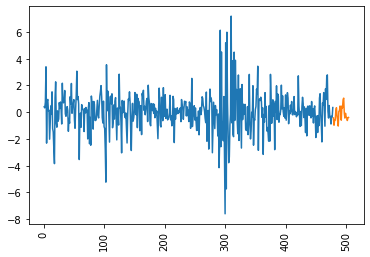

In [34]:
plt.plot(df_train_extended_VZ.index, df_train_extended_VZ.values)
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index, np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

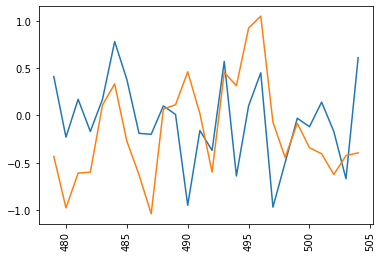

In [35]:
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index,
         diff_test_VZ[ - len(hybrid_prediction):])
plt.plot(diff_test_VZ[ - len(hybrid_prediction):].index,
         np.array(hybrid_prediction))
plt.xticks(rotation=90)
plt.show()

In [36]:
def rmse(y,yhat):
    return np.sqrt(mean_squared_error(y,yhat))

In [37]:
hybrid_rmse = rmse(np.array(diff_test_VZ[ - len(hybrid_prediction):].values),
                   hybrid_prediction)
print('Hybrid RMSE is {:.4f}'.format(hybrid_rmse))

Hybrid RMSE is 0.6224
